## Inverse Cooking: Recipe Generation from Food Images

In [73]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

In [74]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # use GPU 0 and 1


Set ```data_dir``` to the path including vocabularies and model checkpoint

In [75]:
data_dir = '../data'

In [76]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [77]:
# class Vocabulary(object):
#     """Simple vocabulary wrapper."""
#     def __init__(self):
#         self.word2idx = {}
#         self.idx2word = {}
#         self.idx = 0

#     def add_word(self, word, idx=None):
#         if idx is None:
#             if not word in self.word2idx:
#                 self.word2idx[word] = self.idx
#                 self.idx2word[self.idx] = word
#                 self.idx += 1
#             return self.idx
#         else:
#             if not word in self.word2idx:
#                 self.word2idx[word] = idx
#                 if idx in self.idx2word.keys():
#                     self.idx2word[idx].append(word)
#                 else:
#                     self.idx2word[idx] = [word]

#                 return idx

#     def __call__(self, word):
#         if not word in self.word2idx:
#             return self.word2idx['<pad>']
#         return self.word2idx[word]

#     def __len__(self):
#         return len(self.idx2word)

In [78]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
# ingrs_vocab = pickle.load(open("/data/prateek/github/see-food/garbage/recipe1m_vocab_ingrs.pkl", 'rb'))
# ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
# vocab = pickle.load(open('/data/prateek/github/see-food/garbage/recipe1m_vocab_toks.pkl', 'rb')).idx2word
# pickle.dump(ingrs_vocab, open('../garbage/ingr_vocab.pkl', 'wb'))
# pickle.dump(vocab, open('../garbage/instr_vocab.pkl', 'wb'))

# ingrs_vocab = pickle.load(open('/data/prateek/github/see-food/paper_weights/ingr_vocab.pkl', 'rb'))
# vocab = pickle.load(open('/data/prateek/github/see-food/paper_weights/instr_vocab.pkl', 'rb'))

ingrs_vocab = pickle.load(open('/data/prateek/github/see-food/garbage/ingr_vocab.pkl', 'rb'))
vocab = pickle.load(open('/data/prateek/github/see-food/garbage/instr_vocab.pkl', 'rb'))


ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [79]:
print(instrs_vocab_size, ingr_vocab_size)

1631 208


In [86]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = '/data/prateek/github/see-food/checkpoints/inversecooking/ingr_only_vit/checkpoints/modelbest.ckpt'
model.load_state_dict(torch.load(model_path, map_location=map_loc))

model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


using vision: True


Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loaded model
Elapsed time: 2.9812865257263184


In [87]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [88]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [89]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = '../TEST_DATASET/images'

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

# demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
#             'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs
len(demo_files)

517

In [90]:
PRED_FOLDER = "../TEST_DATASET/PRED-baseline/"

instruction_folder = PRED_FOLDER + "/instructions"
title_folder = PRED_FOLDER + "/title"
ingredients_folder = PRED_FOLDER + "/ingredients"

  0%|          | 0/517 [00:00<?, ?it/s]

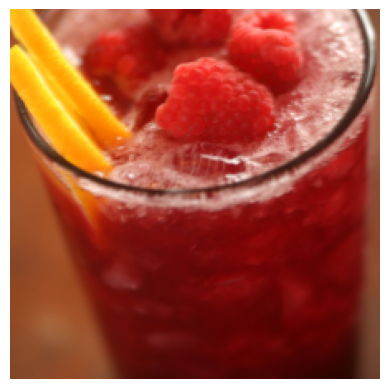

{'title': 'Pita yummy excess croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons notes croutons no

  0%|          | 0/517 [00:10<?, ?it/s]

{'title': 'Pita mash tossing blue better better rest continue spinach evaporated evaporated evaporated panini jalapenos homemade dont 16 onion evaporated bean blueberries soaked super toss warm whatever spinach watermelon spinach cooling drink 425f stack jalapenos 375 cooling keep every brownie sandwiches toaster jalapenos seafood chives jalapenos rest additional jalapenos 375 watermelon evaporated bean pies stack pies watermelon frozen seafood four cake is jalapenos homemade blueberries jalapenos 23 oz splash drops croutons meat spinach splash four cherry every stack jalapenos seafood evaporated cooked spinach blue cooked is frost fit frozen oz spinach blue mug pizza jalapenos rest oz splash bean frost crispy below bean excess seafood jalapenos seafood evaporated bean frost stone. blueberries four pies stack jalapenos seafood jalapenos 23 every 15-20 dumplings stack jalapenos every evaporated stack strainer avocado keep thin frost bubble pickles super jalapenos stone jalapenos flavor 

In [91]:
from tqdm import tqdm

for img_file in tqdm(demo_files):
    recipe = img_file.split(".")[0]
    
    
    try:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    except:
        pass
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    
    numgens = 4
    
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        print(outs)
        print("is valid", valid)

        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print (BOLD + '\nTitle:' + END,outs['title'])

            print (BOLD + '\nIngredients:'+ END)
            print (', '.join(outs['ingrs']))

            print (BOLD + '\nInstructions:'+END)
            print ('-'+'\n-'.join(outs['recipe']))

            print ('='*20)
            
    break

     
        

In [20]:
# from tqdm import tqdm

# for img_file in tqdm(demo_files):
#     recipe = img_file.split(".")[0]
    
    
#     try:
#         image_path = os.path.join(image_folder, img_file)
#         image = Image.open(image_path).convert('RGB')
#     except:
#         with open(title_folder + "/" + recipe + ".txt", "w+") as f:
#             f.write(f"-1\n")
        
#         with open(instruction_folder + "/" + recipe + ".txt", "w+") as f:
#             f.write(f"-1\n")
                
#         with open(ingredients_folder + "/" + recipe + ".txt", "w+") as f:
#             f.write(f"-1\n")
    
#     transf_list = []
#     transf_list.append(transforms.Resize(256))
#     transf_list.append(transforms.CenterCrop(224))
#     transform = transforms.Compose(transf_list)
    
#     image_transf = transform(image)
#     image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
#     # plt.imshow(image_transf)
#     # plt.axis('off')
#     # plt.show()
#     # plt.close()
    
#     num_valid = 1
    
#     numgens = 1
    
#     for i in range(numgens):
#         with torch.no_grad():
#             outputs = model.sample(image_tensor, greedy=greedy[i], 
#                                    temperature=temperature, beam=beam[i], true_ingrs=None)
            
#         ingr_ids = outputs['ingr_ids'].cpu().numpy()
#         recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
#         outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
#         if valid['is_valid'] or show_anyways:
            
#             with open(title_folder + "/" + recipe + ".txt", "w+") as f:
#                 f.write(f"{outs['title']}\n")
            
#             with open(instruction_folder + "/" + recipe + ".txt", "w+") as f:
#                 for item in outs['recipe']:
#                     f.write(f"{item}\n")
                    
#             with open(ingredients_folder + "/" + recipe + ".txt", "w+") as f:
#                 for item in outs['ingrs']:
#                     f.write(f"{item}\n")
            
#             # print ('RECIPE', num_valid)
#             # num_valid+=1
    
#             # BOLD = '\033[1m'
#             # END = '\033[0m'
#             # print (BOLD + '\nTitle:' + END,outs['title'])

#             # print (BOLD + '\nIngredients:'+ END)
#             # print (', '.join(outs['ingrs']))

#             # print (BOLD + '\nInstructions:'+END)
#             # print ('-'+'\n-'.join(outs['recipe']))

#             # print ('='*20)

#         else:
#             with open(title_folder + "/" + recipe + ".txt", "w+") as f:
#                 f.write(f"-1\n")
            
#             with open(instruction_folder + "/" + recipe + ".txt", "w+") as f:
#                 f.write(f"-1\n")
                    
#             with open(ingredients_folder + "/" + recipe + ".txt", "w+") as f:
#                 f.write(f"-1\n")
        

  0%|          | 0/517 [00:00<?, ?it/s]/data/prateek/github/see-food/src/modules/multihead_attention.py:126: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.)
  attn_weights = attn_weights.float().masked_fill(
100%|██████████| 517/517 [19:02<00:00,  2.21s/it]
